Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 125s 2ms/step - loss: 8.5869 - acc: 0.4627 - val_loss: 6.6804 - val_acc: 0.5820
Epoch 2/3
60000/60000 [==============================] - 105s 2ms/step - loss: 6.6159 - acc: 0.5866 - val_loss: 6.5631 - val_acc: 0.5916
Epoch 3/3
60000/60000 [==============================] - 109s 2ms/step - loss: 6.6069 - acc: 0.5886 - val_loss: 6.6625 - val_acc: 0.5845


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

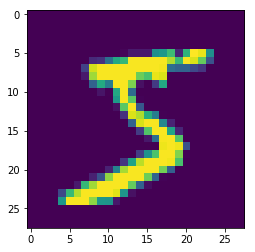

In [38]:
from keras.datasets import mnist
from keras.layers import MaxPooling2D
#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import time
from keras.preprocessing.image import save_img
from keras import backend as K
#plot the first image in the dataset
plt.imshow(X_train[0])

X_train[0].shape

X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, (5,5), activation='relu', input_shape=(28,28,1), name='conv1'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (5,5), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

model.predict(X_test[:4])
y_test[:4]

In [26]:
from keras import applications

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10250     
Total para

In [28]:
input_img = model.input  # Placeholder

In [29]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])  # Help us index different layers in the following steps.

In [30]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [31]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    return x

In [32]:
# Find an input image that maximaly activate the 64 filters in conv1.
kept_filters = []
for filter_index in range(64):
    # we only scan through the first 10 filters,
    # but there are actually 64 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()
    
    layer_output = layer_dict['conv1'].output
    loss = K.sum(layer_output[:, 12, 12, filter_index])  #We had a hard time to realize tha idea, "maximize activation". 
    # It was the artical "How convolutional neural networks see the world" inspired us. 
    # And the method is from the article.
    
    # The gradient of the loss with respect to input image.
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads, when the input picture is given
    iterate = K.function([input_img], [loss, grads])  # This beckend function is also from the article 
    # "How convolutional neural network see the world"
    

    # step size for gradient ascent
    step = 0.2

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, 28, 28, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # we run gradient ascent for 20 steps
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        #print(type(loss_value))
        #print(type(input_img_data))

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
     # decode the resulting input image
    
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Filter 0 processed in 0s
Processing filter 1
Filter 1 processed in 0s
Processing filter 2
Filter 2 processed in 0s
Processing filter 3
Filter 3 processed in 1s
Processing filter 4
Filter 4 processed in 0s
Processing filter 5
Filter 5 processed in 1s
Processing filter 6
Filter 6 processed in 1s
Processing filter 7
Filter 7 processed in 1s
Processing filter 8
Filter 8 processed in 0s
Processing filter 9
Filter 9 processed in 1s
Processing filter 10
Filter 10 processed in 1s
Processing filter 11
Filter 11 processed in 0s
Processing filter 12
Filter 12 processed in 1s
Processing filter 13
Filter 13 processed in 0s
Processing filter 14
Filter 14 processed in 1s
Processing filter 15
Filter 15 processed in 1s
Processing filter 16
Filter 16 processed in 0s
Processing filter 17
Filter 17 processed in 1s
Processing filter 18
Filter 18 processed in 1s
Processing filter 19
Filter 19 processed in 0s
Processing filter 20
Filter 20 processed in 0s
Processing filter 21
Filter 21 pr

In [33]:
#con1 filters
np.shape(kept_filters[0][0][:,:,0])


(28, 28)

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline 

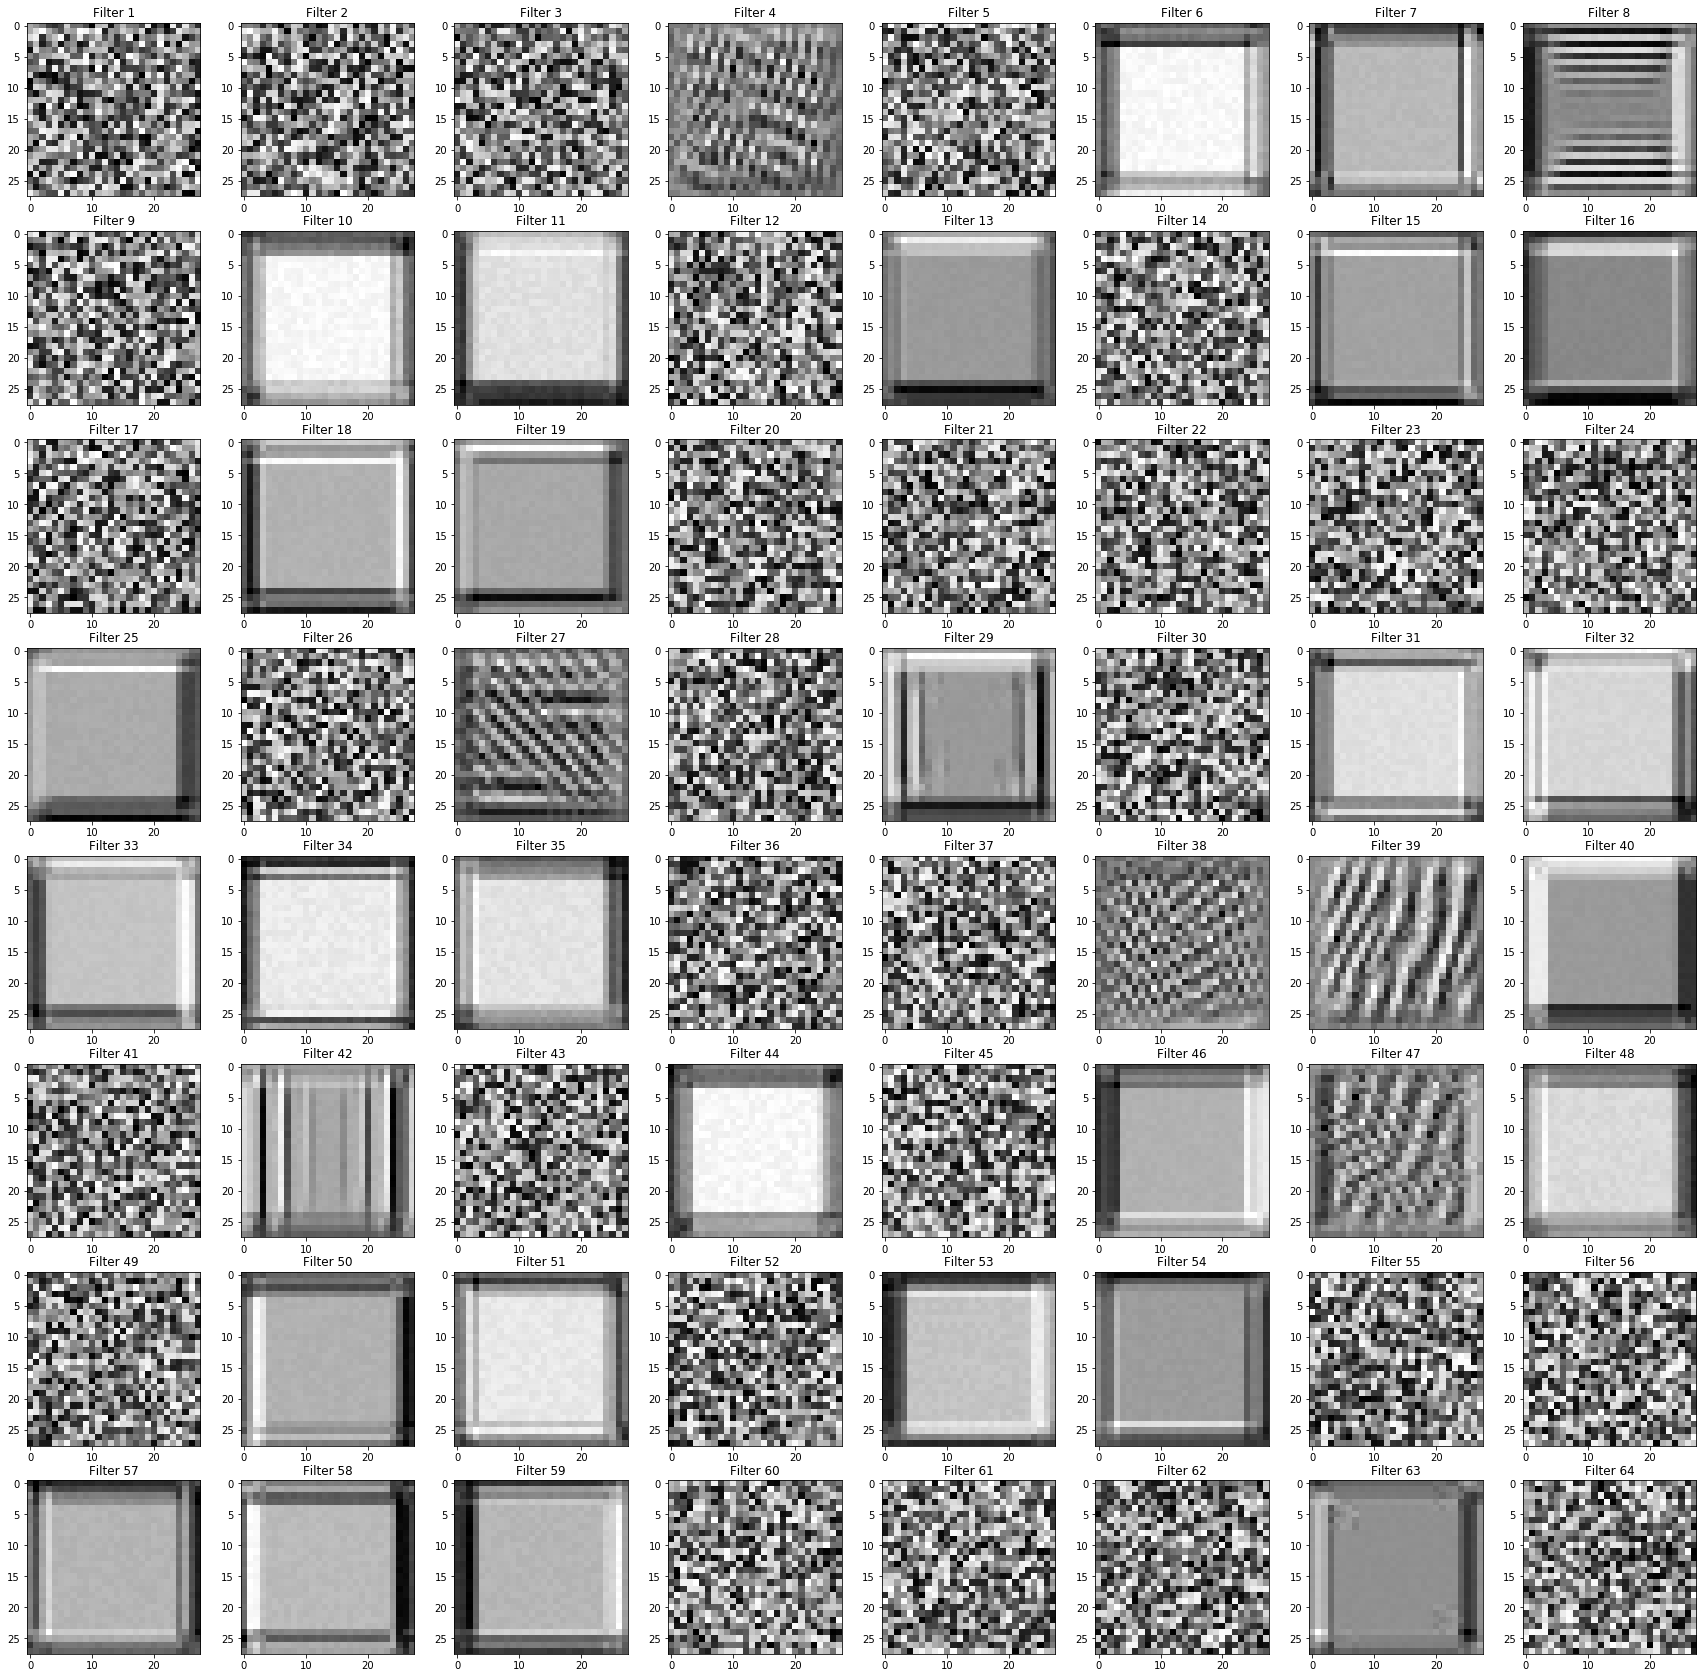

In [35]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0][:,:,0].reshape(28,28),cmap='gray')

In [36]:
# Find an input image that maximaly activate the 64 filters in conv2.
kept_filters_2 = []
for filter_index in range(32):
    # we only scan through the first 10 filters,
    # but there are actually 64 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()
    
    layer_output = layer_dict['conv2'].output
    if K.image_data_format() == 'channels_first':
        loss = K.sum(layer_output[:, filter_index, :, :])
    else:
        loss = K.sum(layer_output[:, :, :, filter_index])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    

    # step size for gradient ascent
    step = 0.2

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 1, 28, 28))  #28*28image
    else:
        input_img_data = np.random.random((1, 28, 28, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # we run gradient ascent for 20 steps
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        #print(type(loss_value))
        #print(type(input_img_data))

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
     # decode the resulting input image
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Filter 0 processed in 0s
Processing filter 1
Filter 1 processed in 0s
Processing filter 2
Filter 2 processed in 2s
Processing filter 3
Filter 3 processed in 0s
Processing filter 4
Filter 4 processed in 0s
Processing filter 5
Filter 5 processed in 0s
Processing filter 6
Filter 6 processed in 0s
Processing filter 7
Filter 7 processed in 2s
Processing filter 8
Filter 8 processed in 0s
Processing filter 9
Filter 9 processed in 0s
Processing filter 10
Filter 10 processed in 2s
Processing filter 11
Filter 11 processed in 2s
Processing filter 12
Filter 12 processed in 2s
Processing filter 13
Filter 13 processed in 2s
Processing filter 14
Filter 14 processed in 2s
Processing filter 15
Filter 15 processed in 0s
Processing filter 16
Filter 16 processed in 2s
Processing filter 17
Filter 17 processed in 0s
Processing filter 18
Filter 18 processed in 3s
Processing filter 19
Filter 19 processed in 2s
Processing filter 20
Filter 20 processed in 0s
Processing filter 21
Filter 21 pr

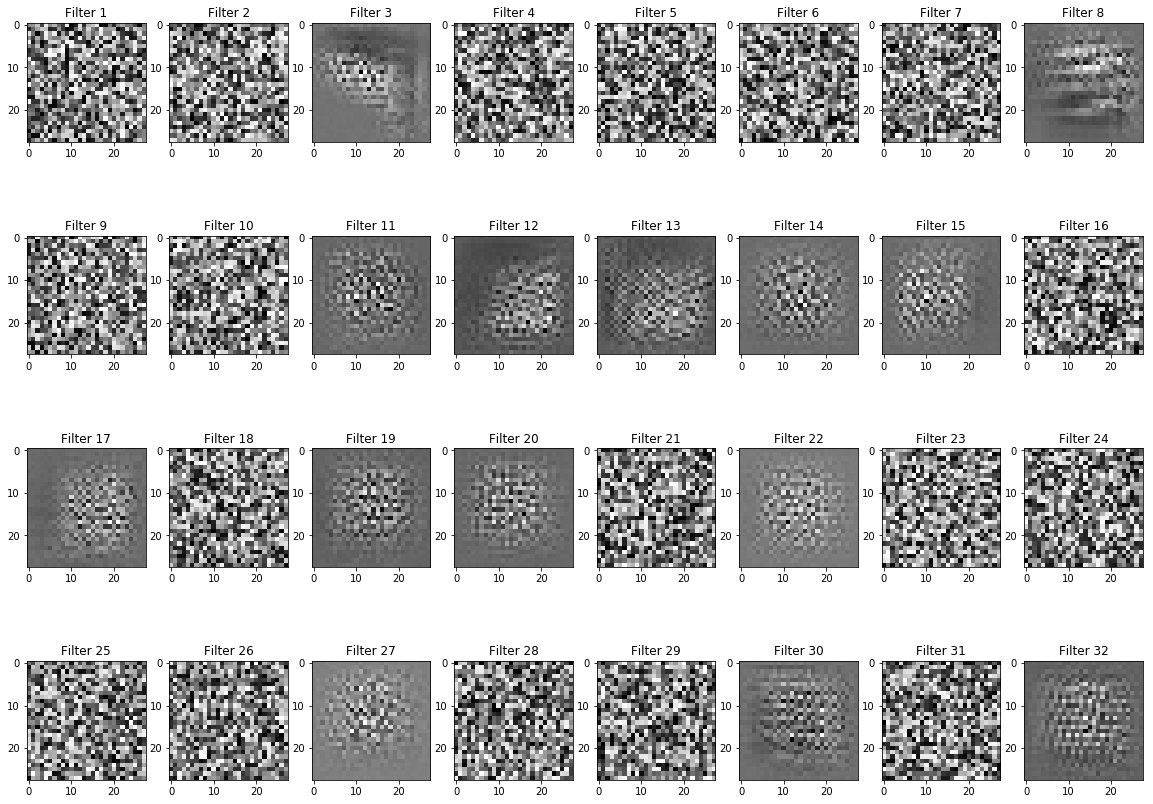

In [37]:
# Show the 64 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(28,28),cmap='gray')

In [20]:
import os
os.getcwd()

'C:\\Users\\liyan'